# fbprophet+ARIMA 앙상블 모델 
## 최종 결과
- public : 19478.06238, 6위
- private : 12862.71498, 29위

## 모델 구성 방법
- fbprophet의 하이퍼 파라미터로 계절성 부분을 조절
- ARIMA의 모수를 찾기 위해 AUTO ARIMA 사용
- 시간 단위를 분 -> 일 로 변경  :  add_seasonality를 사용하면 이렇게 변경하지 않아도 된다. 

In [7]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 시드 고정

In [10]:
import os 
import random
import numpy as np 

#determinism seed
#random
SEED = 375

# random seed 
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds(SEED)
print(SEED)

375


# Library Import

In [11]:
!pip install statsmodels==0.11.1
!pip install fbprophet

     |████████████████████████████████| 8.7MB 7.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [12]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
warnings.filterwarnings("ignore")

# 2. 데이터 불러오기

## 1) read_csv

In [13]:
os.getcwd()

'/content/gdrive/MyDrive'

In [14]:
data_path = os.getcwd()+ '/ModuWay/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## numpy arrary로 변환하기

In [20]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    print(feature_size, time_size, sample_size)
    sample_index = df_2d.sample_id.value_counts().index
    print(sample_index)
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [21]:
print(train_x_df.shape)
train_x_df.head()

(10159560, 12)


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [22]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

10 1380 7362
Int64Index([7360, 2445, 2447, 2446, 2449, 2448, 2451, 2450, 2453, 2452,
            ...
            4904, 4905, 4910, 4911, 4908, 4909, 4914, 4915, 4912,    0],
           dtype='int64', length=7362)
10 120 7362
Int64Index([2047, 3747, 4257, 2210,  163, 6816, 4769, 2722,  675, 7328,
            ...
            1360, 3409, 5458, 1872, 3921, 5970, 2384,  337, 6482,    0],
           dtype='int64', length=7362)
10 1380 529
Int64Index([511, 163, 149, 150, 151, 152, 153, 154, 155, 156,
            ...
            335, 336, 337, 338, 339, 340, 341, 342, 343,   0],
           dtype='int64', length=529)


In [23]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



## 샘플 확인하기

In [24]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [25]:
# 확인할 샘플의 인덱스 
idx = 0 

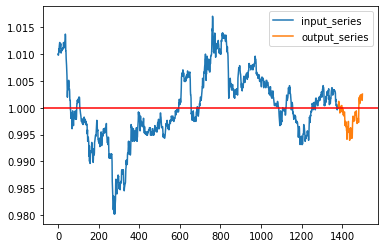

In [27]:
# open 가격 
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1]) # 1-4, open, high, low, close
plt.show()

# fbprophet 모델 훈련하기

## train 샘플 훈련하기

샘플 : 0 인덱스의 open 가격

In [29]:
print(idx)

col_idx = 1 # open 
x_series = train_x_array[idx,:,col_idx]
y_series = train_y_array[idx,:,col_idx]

0


### time 설정 
- 원래 데이터의 의도는 1 time = 1 분 

In [28]:
# start_time = '2018-01-31 00:00:00'
# start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

- daily seasonaility를 사용하기 위해 분 당 데이터를 일 당 데이터로 변경했다.

In [30]:
start_time = '2016-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')
start_dt

datetime.datetime(2016, 1, 31, 0, 0)

In [31]:
x_series.tolist()[:10]

[1.010003924369812,
 1.0098077058792114,
 1.0098077058792114,
 1.0102000236511228,
 1.0109846591949463,
 1.010396122932434,
 1.011376976966858,
 1.0117692947387695,
 1.0121616125106812,
 1.0121616125106812]

### 시간(ds), open가(y)로 구성된 학습데이터 생성

In [32]:
import numpy as np 

x_df = pd.DataFrame()                      # timedelta(minutes=time_min) 으로 설정시 분 당 리스트를 만들 수 있다. 
x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()
x_df.head()

,ds,y
0,2016-02-01,1.010004
1,2016-02-02,1.009808
2,2016-02-03,1.009808
3,2016-02-04,1.010200
4,2016-02-05,1.010985


In [34]:
len(x_df['ds']), len(x_df['y'])

(1380, 1380)

In [35]:
x_df.head()

,ds,y
0,2016-02-01,1.010004
1,2016-02-02,1.009808
2,2016-02-03,1.009808
3,2016-02-04,1.010200
4,2016-02-05,1.010985


### fbprophet hyperparameter tune
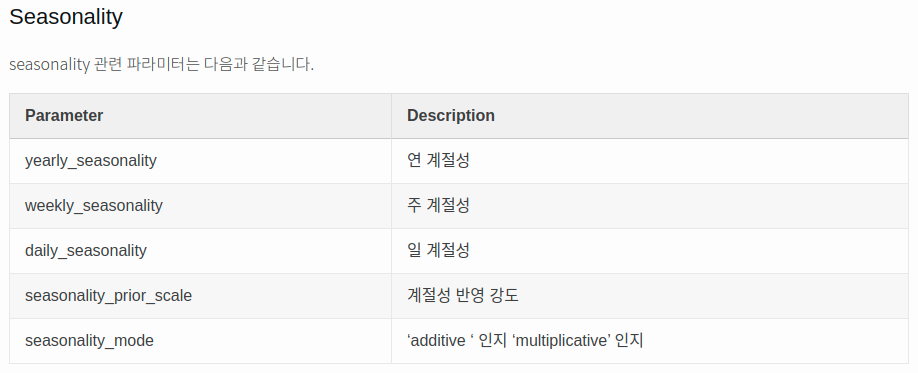
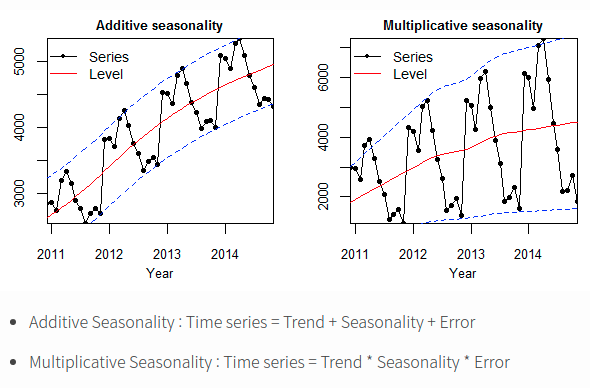
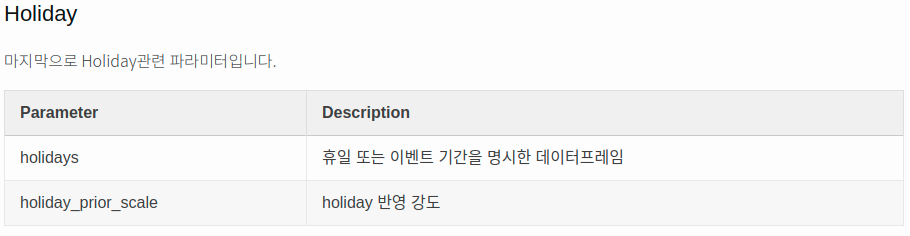
**[image source](https://hyperconnect.github.io/2020/03/09/prophet-package.html)**

In [36]:
# 파라미터 조정
scale = 0.01 # changepoint를 많이 잡도록 
width = 0.95
changepoint_range = 1 

In [7]:
# 신뢰구간의 상한, 하한을 설정할 수 있는 파라미터
# 데이터프레임에 cap, floor 컬럼을 추가해서 설정한다.
#### 설정했으나 floor 쪽으로 예측결과가 치우쳐 사용하지 않았다. 

# x_df['cap'] = 1.1
# x_df['floor'] = 0.5

In [38]:
prophet = Prophet( 
                  yearly_seasonality=False,
                  weekly_seasonality=True, 
                  daily_seasonality=True,
                  changepoint_prior_scale=scale, 
                  interval_width=width, 
                  changepoint_range=changepoint_range,
                  growth='linear',  # logistic
                  seasonality_mode='multiplicative', # 비트코인 가격은 누적된다고 판단, 해당 파라미터를 설정했다.  
                  seasonality_prior_scale=50.0 # seasonality scale 추가 
                  ) 
prophet.fit(x_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [39]:
# 10분을 주기로(periods) 테스트 데이터를 예측합니다.
future_data = prophet.make_future_dataframe(periods=10, freq='d')
# future_data['cap'] = 1.1
# future_data['floor'] = 0.5
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1385,2019-11-17,1.001547,0.997952,1.004999
1386,2019-11-18,1.001530,0.998024,1.005111
1387,2019-11-19,1.001487,0.997866,1.005139
1388,2019-11-20,1.001460,0.997701,1.005053
1389,2019-11-21,1.001460,0.997688,1.005451


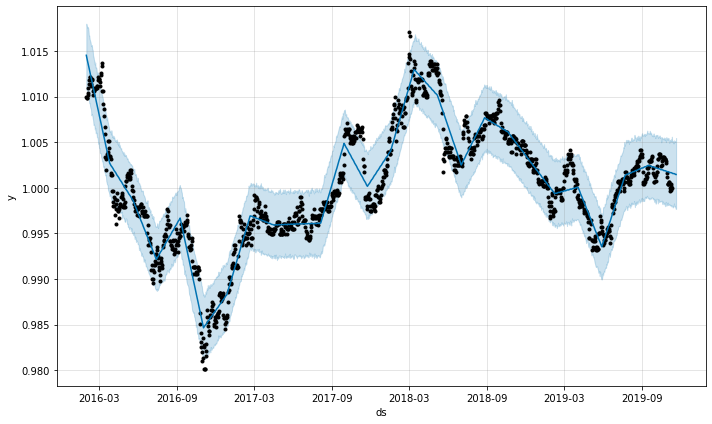

In [40]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

## 예측 결과 시각화 및 분석

120 120 120


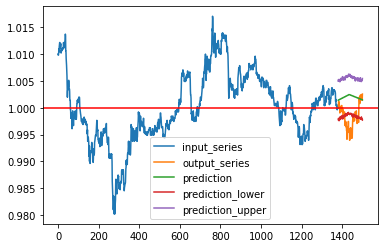

In [41]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

print(len(pred_y), len(pred_y_lower), len(pred_y_upper))

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

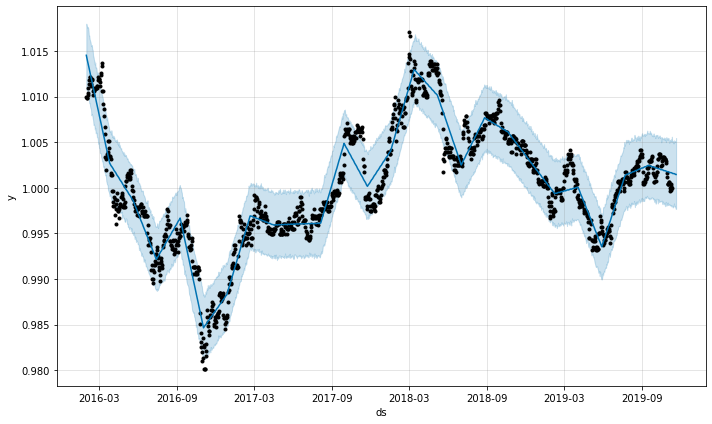

In [42]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

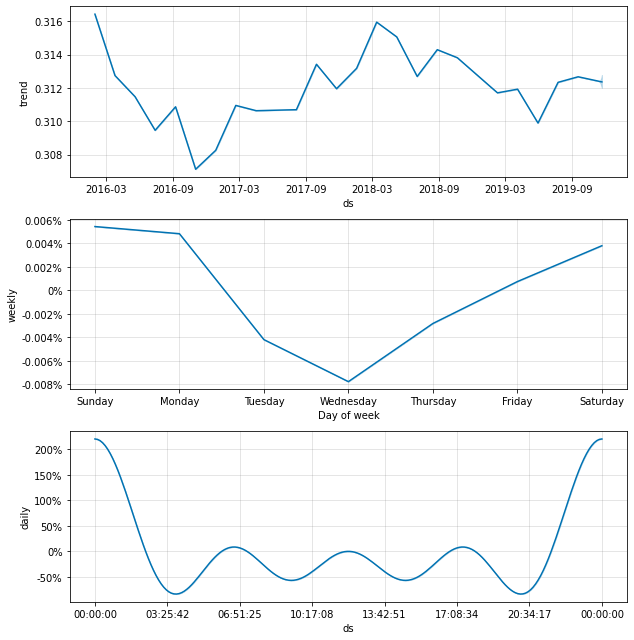

In [43]:
# 데이터의 추세를 확인합니다.
fig2 = prophet.plot_components(forecast_data)

### 예측 결과를 submission 파일로 변환하기
- submission 구성 : [sample id, 매수량, 매도 시간]
- 매수량과 매도시간을 설정한다. 

In [95]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    sell = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
        
    buy_price = np.array(buy_price)
    # 105% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1

    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

### 투자 후 금액 계산하기

In [46]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

## test 데이터 학습하고 추론하기

In [47]:
col_idx = 1 # open기준으로 학습

# 파라미터 조정
scale = 0.01 # changepoint를 많이 잡도록 
width = 0.95
point_range = 1

In [48]:
# 수행시간 30분 정도 걸림 
fb_test_pred_array = np.zeros([test_x_array.shape[0],
                           120])


# sample id 개수만큼 학습을 반복 
# 각 sample id에 대해 따로 학습한다.
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,col_idx]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(days = time_day) for time_day in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet( 
                          yearly_seasonality=False,
                          weekly_seasonality=True, 
                          daily_seasonality=True,
                          changepoint_prior_scale=scale, 
                          interval_width=width, 
                          changepoint_range=point_range,
                          # growth='logistic', # growth 추가
                          growth='linear',
                          seasonality_mode='multiplicative', # seasonality 추가 
                          seasonality_prior_scale=50.0 # seasonality scale 추가 
                          ) 
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='d')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        fb_test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [1:09:24<00:00,  7.87s/it]


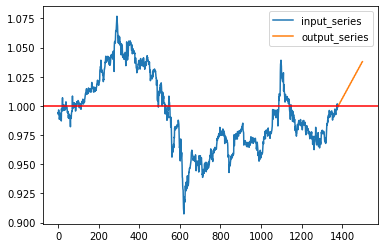

In [49]:
plot_series(x_series, pred_y) # y_series 없음 

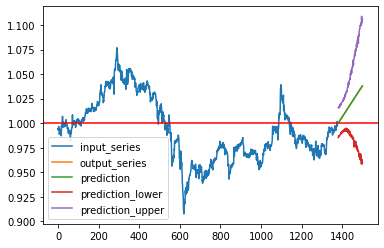

In [50]:
plot_series(x_series, pred_y) # y_series 없음 
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

- 생성한 changepoint를 확인해볼 수 있습니다. 
- 빨간 색으로 표시된 부분이 모델이 감지한 changepoint

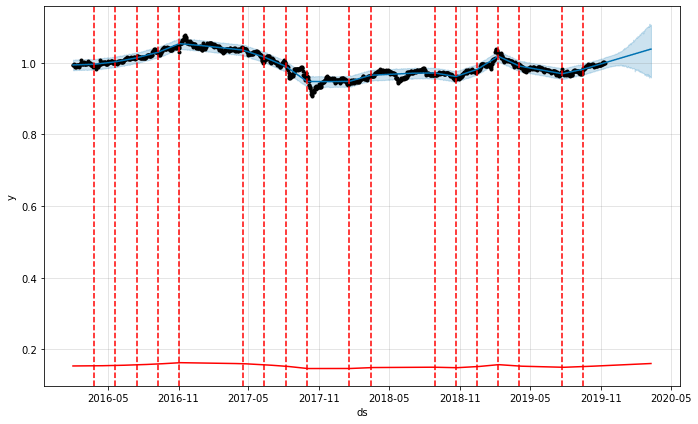

In [61]:
from fbprophet.plot import add_changepoints_to_plot

fig = prophet.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast_data)

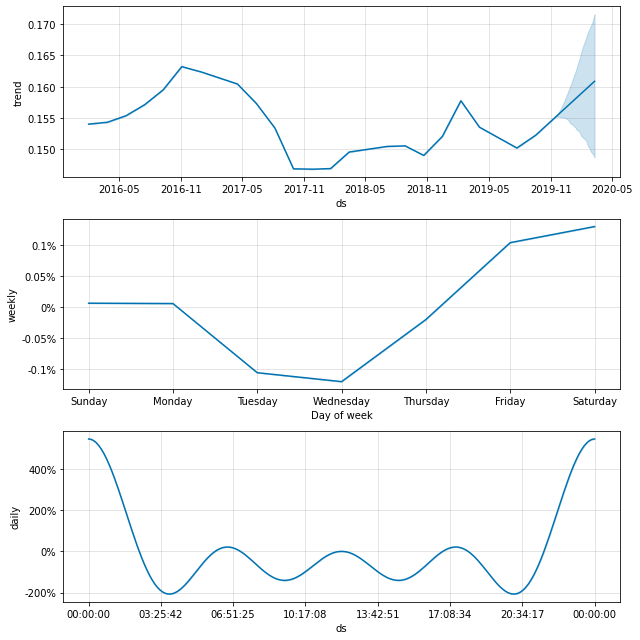

In [62]:
# 데이터의 추세를 확인합니다.
fig2 = prophet.plot_components(forecast_data)

In [55]:
fb_test_pred_array.shape, test_x_array.shape

((529, 120), (529, 1380, 10))

In [58]:
submission = array_to_submission(test_x_array, test_pred_array)

# ARIMA 모델 훈련하기

In [63]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.6MB/s 
     |████████████████████████████████| 2.1MB 37.9MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


### 최적의 모수를 찾기위해 AUTO ARIMA사용
- 결과는 좋지 않았다. 

In [68]:
from pmdarima.arima import auto_arima

# m=0 : non-seasonal
model_autoARIMA = auto_arima(x_series,
                             test='adf',
                            trace=True, 
                            error_action='ignore', 
                            start_p=4, start_q=4,
                            max_p=10, max_q=10,
                             D=1,
                            suppress_warnings=True,
                            stepwise=True,
                            seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-11903.781, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11884.303, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11899.721, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11900.970, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11886.300, Time=0.12 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-11901.369, Time=1.86 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-11901.636, Time=1.56 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=-11902.374, Time=2.31 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=-11904.982, Time=2.10 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=-11903.399, Time=1.56 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=-11905.586, Time=2.60 sec
 ARIMA(6,1,5)(0,0,0)[0] intercept   : AIC=-11862.303, Time=1.16 sec
 ARIMA(5,1,6)(0,0,0)[0] intercept   : AIC=-11862.302, Time=1.91 sec
 ARIMA(4,1,6)(0,0,0)[0] intercept   : AIC=-11903.794, Time=2.81 sec
 ARIM

In [69]:
print(model_autoARIMA.aic())

-11907.579545537104


In [74]:
arima_p = 5
arima_q = 1
arima_d = 5

## test 데이터 학습하고 추론하기

In [75]:
arima_test_pred_array = np.zeros([test_x_array.shape[0], 120])

for idx in tqdm(range(test_x_array.shape[0])):
    try:
        try:
            x_series = test_x_array[idx,:,1]

            model = ARIMA(x_series, order=(arima_p,arima_q,arima_d))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            arima_test_pred_array[idx,:] = preds
        except:
            x_series = test_x_array[idx,:,1]

            model = ARIMA(x_series, order=(arima_p-1,arima_q,arima_d))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            arima_test_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [13:18<00:00,  1.51s/it]


## 추론한 test_pred_array를 바탕으로 submission df 생성하기
**- ARIMA**

In [96]:
arima_submission = array_to_submission(test_x_array, arima_test_pred_array)
arima_submission.buy_quantity.value_counts()

0    402
1    127
Name: buy_quantity, dtype: int64

- fbprophet

In [97]:
fb_submission = array_to_submission(test_x_array, fb_test_pred_array)
fb_submission.buy_quantity.value_counts()

0    470
1     59
Name: buy_quantity, dtype: int64

## fbprophet + ARIMA
- 학습 결과 array의 평균을 사용합니다. 

In [76]:
ensemble_pred_array = (fb_test_pred_array + arima_test_pred_array)/2

- 학습결과로 submission파일을 생성합니다. (매수량, 매도시간)

In [98]:
ensemble_submission = array_to_submission(test_x_array, ensemble_pred_array)

- 최종결과로 52번의 매수를 진행했습니다. 
    - 이는 105%이상 상승할 것이라고 예측한 결과 샘플이 52개라는 뜻입니다.

In [99]:
ensemble_submission.buy_quantity.value_counts()

0    477
1     52
Name: buy_quantity, dtype: int64

In [100]:
ensemble_submission.to_csv(data_path+"/ensemble_proh_scale={}_width={}_range={}_{}.csv".format(
                                     scale, width, point_range, time.strftime('%H%M%S')), index = False)